# Capstone -  Pneumonia Detection
### By Group 7 (CV1)

Members - 
  - Payal bhattacherjee
  
  - M. Firos
  
  - Lakshmi
  
  - Piyush Singh
  
  - Yashovardhan Sharma

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [5]:
import tensorflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.patches as patches
import seaborn as sns
import pydicom as dicom
import pylab
from sklearn import svm
import os
os.chdir('/content/drive/MyDrive/Capstone - Pneumonia Detection')
import cv2
from scipy.stats import zscore
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, MaxPooling2D, Concatenate, Reshape, UpSampling2D
from tensorflow.keras import regularizers, optimizers
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
tensorflow.__version__

%matplotlib inline
sns.set(color_codes=True) 

In [6]:
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the Data

In [ ]:
images_path = '/content/drive/MyDrive/Capstone - Pneumonia Detection/rsna-pneumonia-detection-challenge.zip'

from zipfile import ZipFile
with ZipFile(images_path,'r') as zip:
  zip.extractall()

In [7]:
!ls

 Annotated			        stage_2_test_images
 Annots.csv			        stage_2_train_images
 coco_annotation.py		        stage_2_train_images_jpg_converted
 Combined.csv			        stage_2_train_labels.csv
 convert.py			        train_bottleneck.py
 darknet53.cfg			        train.py
 font				        Tutorial.ipynb
'For Roboflow'			        Untitled0.ipynb
'GCP Credits Request Link - RSNA.txt'  'use this'
 keras-yolo3			        voc_annotation.py
 kmeans.py			        yolo3
 LICENSE			        yolo.py
 model_data			        yolov3.cfg
 README.md			        yolov3-tiny.cfg
'Reworked for Roboflow'		        yolov3.weights
 stage_2_detailed_class_info.csv        yolov5
 stage_2_sample_submission.csv	        yolo_video.py


## Exploratory Data Analysis

### Sample Image

In [8]:
image_sample_path = os.listdir('./stage_2_train_images')[:1]
print(image_sample_path)

['f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm']


In [9]:
import pydicom
sample = pydicom.read_file('./stage_2_train_images/a5122049-489e-4c01-b8f3-2de734058d2a.dcm') 
print(sample)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.2151.1517874294.898960
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2151.1517874294.898960
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

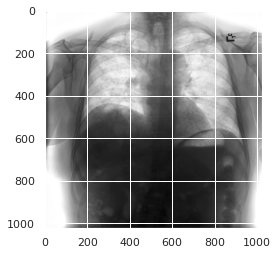

In [10]:
plt.imshow(sample.pixel_array, cmap=pylab.cm.binary)

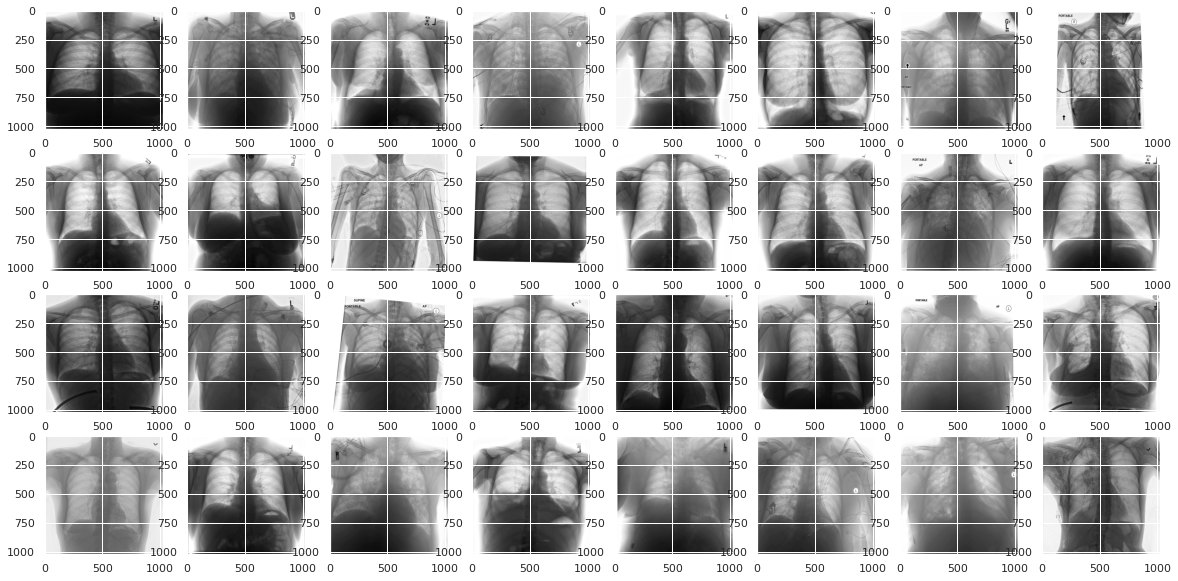

In [11]:
train_dir = './stage_2_train_images/'
train_images = [f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]

fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    ds = pydicom.dcmread(train_dir + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=pylab.cm.binary)
    fig.add_subplot

### Total Number of Images in the Train & Test Set

In [12]:
train_count = os.listdir('./stage_2_train_images')
test_count = os.listdir('./stage_2_test_images')
print("Number of images in the train set:", len(train_count))
print("Number of images in the test set:", len(test_count))

Number of images in the train set: 26684
Number of images in the test set: 3000


### Label info

In [13]:
train_label = pd.read_csv('./stage_2_train_labels.csv')

In [14]:
train_label.info

<bound method DataFrame.info of                                   patientId      x  ...  height  Target
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN  ...     NaN       0
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN  ...     NaN       0
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN  ...     NaN       0
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN  ...     NaN       0
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  ...   379.0       1
...                                     ...    ...  ...     ...     ...
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  ...   379.0       1
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN  ...     NaN       0
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN  ...     NaN       0
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  ...   345.0       1
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  ...   356.0       1

[30227 rows x 6 columns]>

In [15]:
train_label.shape

(30227, 6)

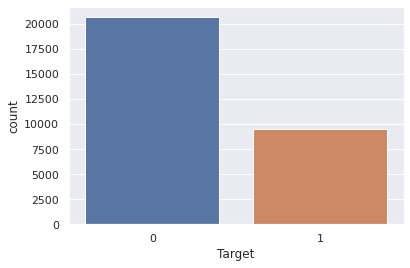

In [16]:
sns.countplot(train_label['Target'])

In [17]:
train_label.groupby('Target').count() 

,patientId,x,y,width,height
Target,,,,,
0,20672,0,0,0,0
1,9555,9555,9555,9555,9555


### We have 20672 samples with no opacity, whereas 9555 samples with opacity (pneumonia)

In [18]:
train_label.groupby('patientId').count() 

,x,y,width,height,Target
patientId,,,,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,0,0,0,1
000924cf-0f8d-42bd-9158-1af53881a557,0,0,0,0,1
000db696-cf54-4385-b10b-6b16fbb3f985,2,2,2,2,2
000fe35a-2649-43d4-b027-e67796d412e0,2,2,2,2,2
001031d9-f904-4a23-b3e5-2c088acd19c6,2,2,2,2,2
...,...,...,...,...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,2,2,2,2,2
fffba05a-1635-4545-9bbd-57ad4cfe8d27,0,0,0,0,1
fffc95b5-605b-4226-80ab-62caec682b22,0,0,0,0,1


### The interesting thing is that there are some patients with two targets or two boxes. There are only 26684 unique patients

In [19]:
grouped_by_patient = train_label.groupby('patientId').sum()

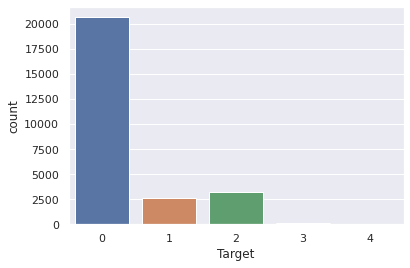

In [20]:
sns.countplot(grouped_by_patient['Target'])

In [21]:
grouped_by_patient.groupby('Target').count() 

,x,y,width,height
Target,,,,
0,20672,20672,20672,20672
1,2614,2614,2614,2614
2,3266,3266,3266,3266
3,119,119,119,119
4,13,13,13,13


### What this means is that there are:

*   20672 entries with 0 opacities
*   2614 patients with 1 opacity
*   3266 patients with 2 opacities
*   119 patients with 3 opacities
*   13 patients with 4 opacities



In [22]:
grouped_by_patient.head()

,x,y,width,height,Target
patientId,,,,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0
000db696-cf54-4385-b10b-6b16fbb3f985,976.0,693.0,316.0,880.0,2
000fe35a-2649-43d4-b027-e67796d412e0,653.0,509.0,565.0,847.0,2
001031d9-f904-4a23-b3e5-2c088acd19c6,618.0,324.0,749.0,1284.0,2


In [23]:
train_label.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


### Visualizing Bounding Boxes

In [29]:
# Plotting bounding boxes on the images

starting_path = '/content/drive/MyDrive/Capstone - Pneumonia Detection/stage_2_train_images/'

def plot(index):
    fig,ax = plt.subplots(1)

    ds = dicom.dcmread(starting_path + train_label['patientId'][index] + '.dcm')
    # Display the image
    ax.imshow(ds.pixel_array, cmap=pylab.cm.binary)

    rect = patches.Rectangle((train_label['x'][index], 
                               train_label['y'][index]), 
                              train_label['width'][index], 
                              train_label['height'][index],
                              linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()


In [30]:
train_label.loc[[0]]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0


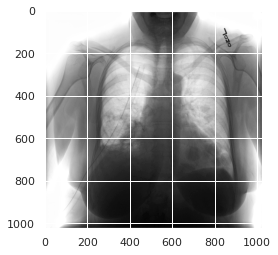

In [31]:
plot(0)


In [32]:
train_label.loc[[4]]

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


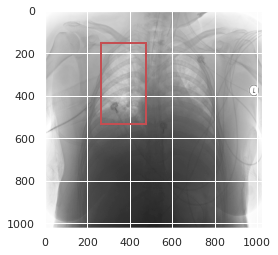

In [33]:
plot(4)

In [34]:
train_label.loc[[5]]

,patientId,x,y,width,height,Target
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


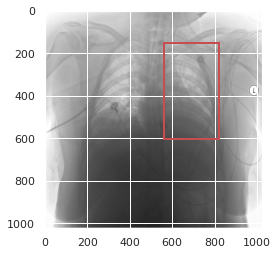

In [35]:
plot(5)

### Analyzing Bounding Box Dimensions

Distribution of x, y, width and height:

In [36]:
train_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [37]:
train_label.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


#### Let’s look at the distribution of x (in cases where pneumonia is detected), to get a rough sense of where the pneumonia lies:

From the below we can safely say that there is equal likelihood of pneumonia to be present in either lungs (and the data doesn’t have a bias with respect to a particular lung)

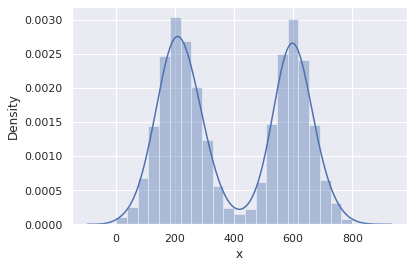

In [38]:
sns.distplot(train_label["x"])

#### Let’s now look at the distribution of y (in cases where pneumonia is detected) also:

We can see from the below that there are roughly two peaks, but still the distribution is mostly normal. For most of the cases, the top of the box is roughly starting around 20-50% of the image (200-500 px out of 1000 px). Again, this means that the data hardly has any outlier in terms of lung position and all. It also suggests that all the images follow a particular orientation.

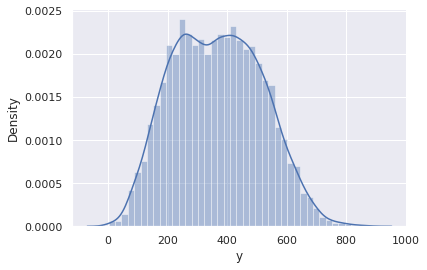

In [39]:
sns.distplot(train_label["y"])

#### Distribution of width (of the bounding box):

Width of the boxes are following a near normal distribution with a peak around 200. This is in sync with the width of an infected lung.


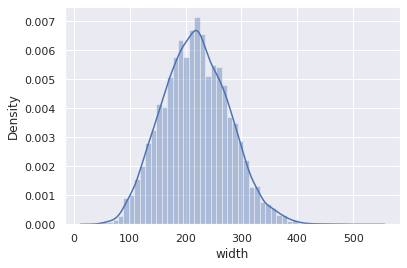

In [40]:
sns.distplot(train_label["width"])

#### Distribution of height (of the bounding box):

From the above, it can be inferred that the distribution has a long tail on the right side. No significant outliers.

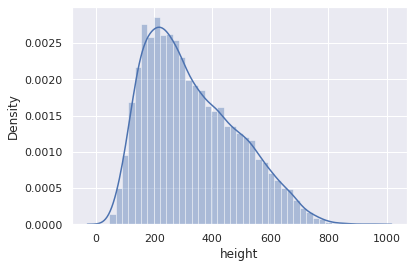

In [41]:
sns.distplot(train_label["height"])

### Class info

In [42]:
class_info = pd.read_csv('./stage_2_detailed_class_info.csv')
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [43]:
class_info['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

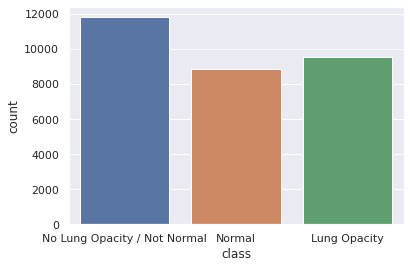

In [44]:
sns.countplot(class_info['class']);

In [45]:
class_info.isnull().sum(axis=0)

patientId    0
class        0
dtype: int64

### Combining both the train label and class data

In [46]:
combined = train_label.merge(class_info,left_on='patientId', right_on='patientId', how='inner')
combined.drop_duplicates(inplace=True)
combined.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [47]:
combined.count()

patientId    30227
x             9555
y             9555
width         9555
height        9555
Target       30227
class        30227
dtype: int64

In [49]:
combined.groupby(['class', 'Target']).size().reset_index(name='Total Patient Count')

,class,Target,Total Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


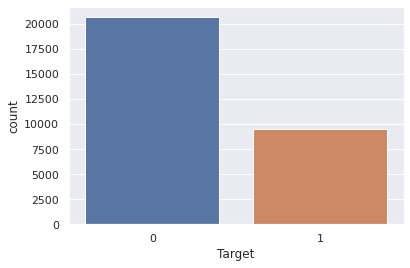

In [50]:
sns.countplot(combined['Target']);

### Location of pneumonia in lungs

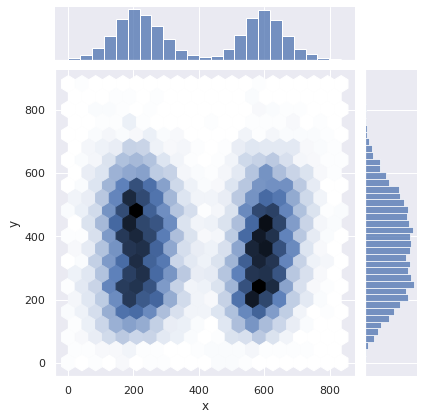

In [51]:
sns.jointplot(x = 'x', y = 'y', data = combined, kind = 'hex', gridsize = 20);

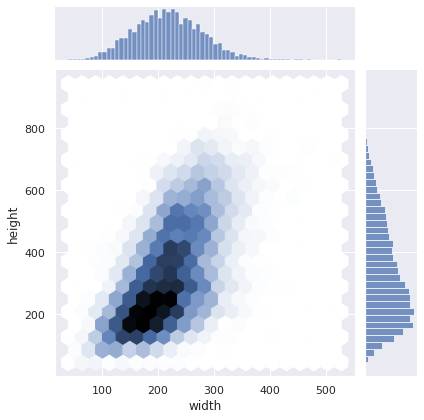

In [52]:
sns.jointplot(x = 'width', y = 'height', data = combined, kind = 'hex', gridsize = 20);

### Images of each class

#### 1. First with lung capacity

In [53]:
lung_opacity = combined.loc[(combined['class'] == 'Lung Opacity' )].reset_index(drop=True).drop_duplicates(keep='first')
lung_opacity['class'].value_counts()

Lung Opacity    9555
Name: class, dtype: int64

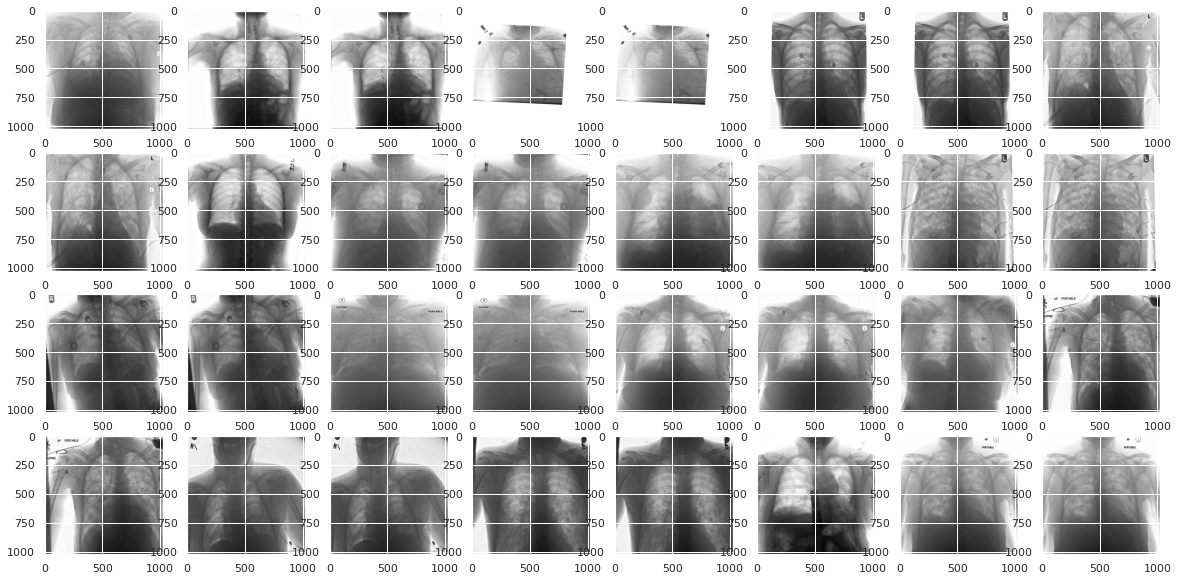

In [56]:
fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    train_dir = './stage_2_train_images/'
    filename = lung_opacity['patientId'][i] + '.dcm'
    images = (os.path.join(train_dir,filename))
    im = pydicom.dcmread(images)
    fig.add_subplot(rows, columns, i)
    plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

#### 2. Examples for No Lung Opacity / Not Normal

In [57]:
not_normal = combined.loc[(combined['class'] == 'No Lung Opacity / Not Normal')].reset_index(drop=True) 
not_normal['class'].value_counts()

No Lung Opacity / Not Normal    11821
Name: class, dtype: int64

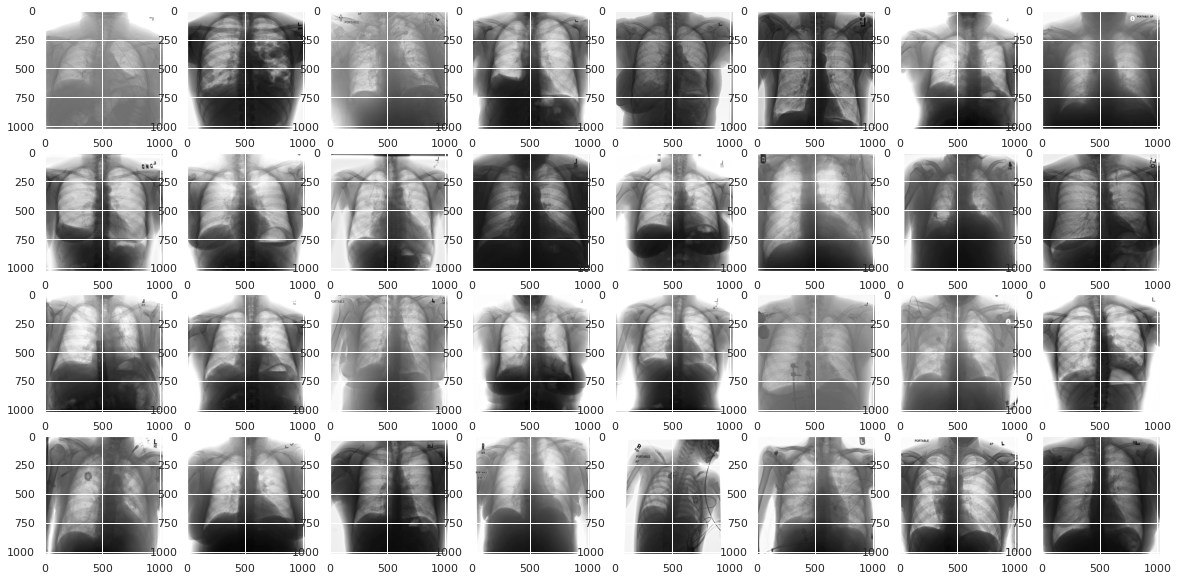

In [58]:
fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    train_dir = './stage_2_train_images/'
    filename = not_normal['patientId'][i] + '.dcm'
    images = (os.path.join(train_dir,filename))
    im = pydicom.dcmread(images)
    fig.add_subplot(rows, columns, i)
    plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

#### 3. Examples for Normal (No Pneumonia)

In [59]:
normal = combined.loc[(combined['class'] == 'Normal')].reset_index(drop=True) 
normal['class'].value_counts()

Normal    8851
Name: class, dtype: int64

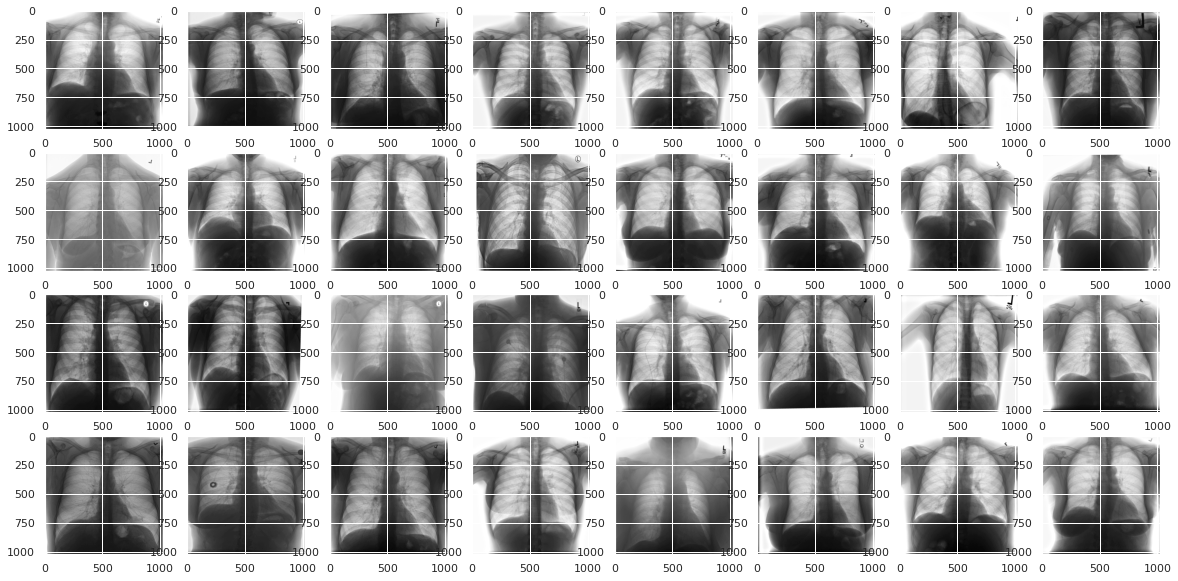

In [60]:
fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    train_dir = './stage_2_train_images/'
    filename = normal['patientId'][i] + '.dcm'
    images = (os.path.join(train_dir,filename))
    im = pydicom.dcmread(images)
    fig.add_subplot(rows, columns, i)
    plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

#### Side by Side Comparison of all three Classes

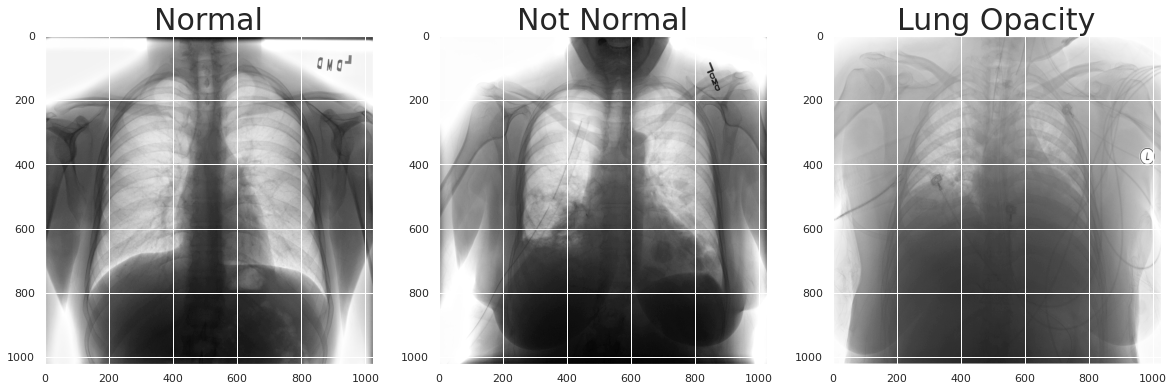

In [61]:
fig=plt.figure(figsize=(20, 10))
columns = 3; rows = 1

fig.add_subplot(rows, columns, 1).set_title("Normal", fontsize=30)
train_dir = './stage_2_train_images/'
filename = normal['patientId'][0] + '.dcm'
images = (os.path.join(train_dir,filename))
im = pydicom.dcmread(images)
plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

fig.add_subplot(rows, columns, 2).set_title("Not Normal", fontsize=30)
train_dir = './stage_2_train_images/'
filename = not_normal['patientId'][0] + '.dcm'
images = (os.path.join(train_dir,filename))
im = pydicom.dcmread(images)
plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

fig.add_subplot(rows, columns, 3).set_title("Lung Opacity", fontsize=30)
train_dir = './stage_2_train_images/'
filename = lung_opacity['patientId'][0] + '.dcm'
images = (os.path.join(train_dir,filename))
im = pydicom.dcmread(images)
plt.imshow(im.pixel_array, cmap=pylab.cm.binary)

### Metadata for all Training Images

In [62]:
sample

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.2151.1517874294.898960
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2151.1517874294.898960
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [63]:
def get_info(patientId, root_dir='./stage_2_train_images/'):
    fn = os.path.join(root_dir, f'{patientId}.dcm')
    dcm_data = pydicom.read_file(fn)
    return {'age': dcm_data.PatientAge, 
            'gender': dcm_data.PatientSex,
            'modality': dcm_data.Modality, 
            'id': os.path.basename(fn).split('.')[0]
            }

ids = list(combined['patientId'].unique())

In [64]:
with multiprocessing.Pool(4) as pool:
    result = pool.map(get_info, ids)

In [65]:
metadata = pd.DataFrame(result)
metadata['age'] = metadata['age'].astype(int)
metadata['gender'] = metadata['gender'].astype('category')

In [66]:
combined = (combined.merge(metadata, left_on='patientId', right_on='id', how='left').drop(columns='id'))

# combined = pd.read_csv('Combined.csv')
combined.head()

,patientId,x,y,width,height,Target,class,age,gender,modality
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,F,CR
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,F,CR
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,M,CR
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,M,CR
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32,F,CR


#### Age Distribution between Target

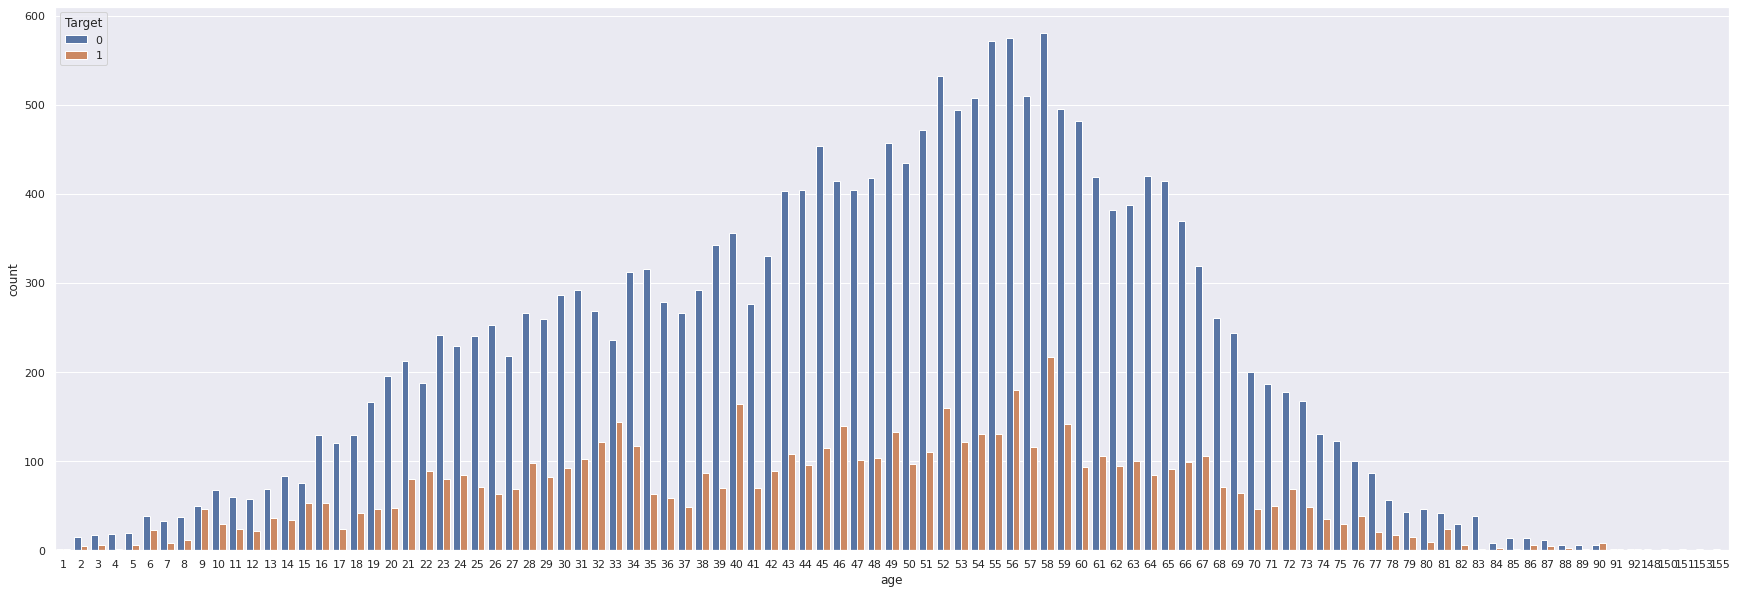

In [67]:
plt.figure(figsize = (30, 10))
sns.countplot(x = 'age', hue = 'Target', data = combined.drop_duplicates(subset=['patientId']))

#### Gender Distribution between Target

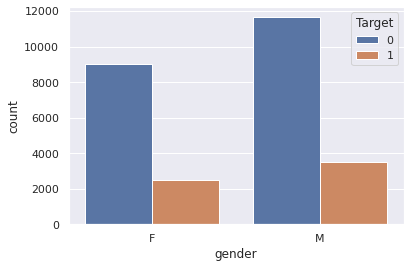

In [68]:
sns.countplot(x = 'gender', hue = 'Target', data = combined.drop_duplicates(subset=['patientId']))

#### Statistical Analysis of the data

In [69]:
combined.describe()

,x,y,width,height,Target,age
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108,46.797764
std,204.574172,148.940488,59.289475,157.750755,0.464963,16.892940
min,2.000000,2.000000,40.000000,45.000000,0.000000,1.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000,34.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000,49.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000,59.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000,155.000000


In [70]:
combined.corr()

,x,y,width,height,Target,age
x,1.000000,0.007604,-0.058665,0.008256,NaN,-0.016081
y,0.007604,1.000000,-0.299897,-0.645369,NaN,0.104195
width,-0.058665,-0.299897,1.000000,0.597461,NaN,0.027666
height,0.008256,-0.645369,0.597461,1.000000,NaN,-0.006048
Target,NaN,NaN,NaN,NaN,1.000000,-0.056878
age,-0.016081,0.104195,0.027666,-0.006048,-0.056878,1.000000


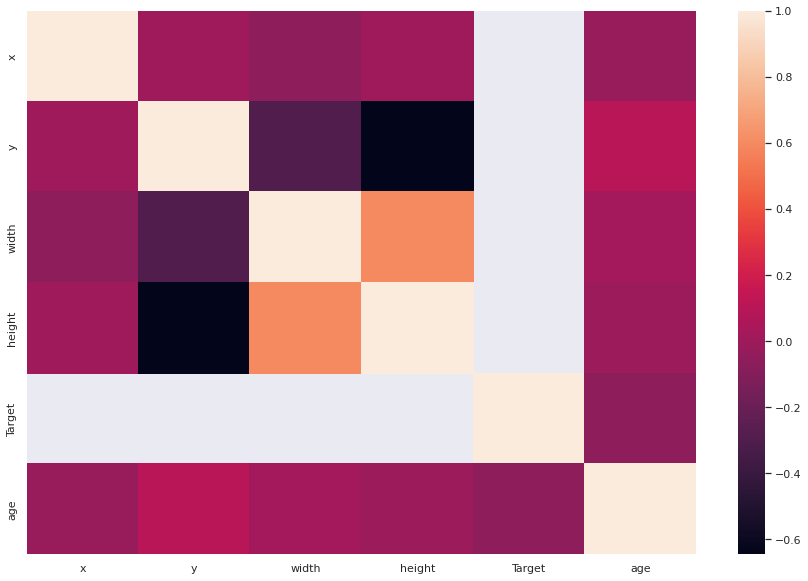

In [71]:
plt.figure(figsize=(15,10))
sns.heatmap(combined.corr())

#### Outliers?

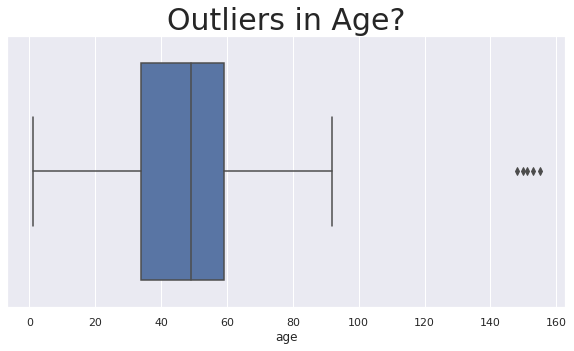

In [77]:
fig=plt.figure(figsize=(10, 5))

fig.add_subplot(rows, columns, 1).set_title("Outliers in Age?", fontsize=30)
sns.boxplot(combined['age'])

In [80]:
combined.loc[(combined['age'] >= 100)].reset_index(drop=True)

,patientId,x,y,width,height,Target,class,age,gender,modality
0,3b8b8777-a1f6-4384-872a-28b95f59bf0d,NaN,NaN,NaN,NaN,0,Normal,148,M,CR
1,73aeea88-fc48-4030-8564-0a9d7fdecac4,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,151,F,CR
2,a4e8e96d-93a6-4251-b617-91382e610fab,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,153,M,CR
3,ec3697bd-184e-44ba-9688-ff8d5fbf9bbc,NaN,NaN,NaN,NaN,0,Normal,150,M,CR
4,f632328d-5819-4b29-b54f-adf4934bbee6,NaN,NaN,NaN,NaN,0,Normal,155,F,CR


## Data Generator

### Converting Dicom to .PNG/ .JPG

In [81]:
inputdir = './stage_2_train_images/'
outdir = './stage_2_train_images_jpg_converted/'
os.mkdir(outdir)

train_list = [ f for f in  os.listdir(inputdir)]

for f in train_list:
    ds = pydicom.read_file(inputdir + f) # read dicom image
    img = ds.pixel_array # get image
    cv2.imwrite(outdir + f.replace('.dcm','.jpg'),img) # write jpg image

In [82]:
train_count = os.listdir('./stage_2_train_images')
jpg_count = os.listdir('./stage_2_train_images_jpg_converted')
print("Number of images in the train set:", len(train_count))
print("Number of images that have been converted to .jpg:", len(jpg_count))

Number of images in the train set: 26684
Number of images that have been converted to .jpg: 26684
